# **DATA PREPROCESSING**

Below, our group will report on the issues we encountered during the data preprocessing stage and how we handled them.

### **Issues encountered during the data processing:**

In [1]:
import pandas as pd
import numpy as np 
import csv
import re
from difflib import SequenceMatcher

From the input file (containing raw data crawled from the web), we will perform data preprocessing steps to clean the data, and then output the results into an output file (containing the cleaned data after all preprocessing steps).

In [2]:
# Đường dẫn tới file CSV đầu vào 
file_input = '../Data/temp_data.csv'
# Đường dẫn tới file CSV đầu ra
file_output = '../Data/clean_data.csv'

#### **Issue 01:**

When initially crawling data from the web (raw data), I encountered an error that prevented the execution of the `pd.read_csv` command. Upon a preliminary inspection, I discovered that the error was due to extra quotation marks in the data string, which caused the data structure to be incorrect.

In [3]:
# Hàm sửa lỗi dư hoặc thiếu dấu ngoặc kép trong file CSV
def fix_csv_quotes(file_input, file_output):
    # Mở file đầu vào để đọc và file đầu ra để ghi
    with open(file_input, 'r', encoding = 'utf-8') as infile, open(file_output, 'w', newline = '', encoding = 'utf-8') as outfile:
        # Đọc tất cả các dòng từ file đầu vào
        reader = infile.readlines()
        # Tạo writer để ghi vào file đầu ra
        writer = csv.writer(outfile)

        # Lặp qua từng dòng trong file đầu vào
        for line in reader:
            # Kiểm tra số lượng dấu ngoặc kép trong dòng
            num_quotes = line.count('"')
            # Nếu số lượng dấu ngoặc kép là số lẻ, thêm một dấu ngoặc kép ở cuối dòng
            if num_quotes % 2 != 0:
                line = line.strip() + '"\n'
            # Ghi lại dòng đã sửa vào file đầu ra
            writer.writerow(next(csv.reader([line], skipinitialspace = True)))

Use the `fix_csv_quotes` function to appropriately adjust the pairs of quotation marks (" ") in the data.

In [4]:
fix_csv_quotes(file_input, file_output)

#### **Issue 02:**

The data in the columns of the CSV file is not clean; specifically, there are unnecessary characters and special characters that could significantly impact subsequent processes.

In [5]:
column_index = 8  # Chỉ số của cột cần làm sạch (bắt đầu từ 0), cột 8 là cột Description

def clean_string(string):

    """
    Hàm này sẽ làm sạch chuỗi bằng cách loại bỏ các biểu tượng và ký tự không cần thiết.
    (nhưng giữ lại các kí tự chữ (hoa và thường), số, dấu chấm, dấu phẩy, dấu | )
    
    string: Chuỗi cần làm sạch.
    cleanString: Chuỗi đã được làm sạch.

    """

    # Hàm isinstance check xem data input của mình có phải là string không 
    if isinstance(string, str):
        cleanString = re.sub(r'[^\w\s.,|]', '', string) # Xoá tất cả các kí tự ngoại trừ chữ (thường, hoa), số, dấu chấm, dấu phẩy, dấu |
        return cleanString
    else:
        return string

In [6]:
def clean_file_csv(file_input, file_output, column_index):

    """
    Hàm này sẽ làm sạch một cột cụ thể trong file CSV, do có những cột khác (VD cột Postdate có dấu : ), 
    Vì vậy nếu apply full file csv nó sẽ fix hết cả những cột không cần thiết -> chỉ áp dụng chính xác cột cần xử lí thôi.

    input_csv (str): Đường dẫn tới file CSV đầu vào (temp_data).
    output_csv (str): Đường dẫn tới file CSV đầu ra (clean_data).
    column_index (int): Chỉ số của cột cần làm sạch.
    """

    # Đọc file CSV vào DataFrame
    df = pd.read_csv(file_input, on_bad_lines = 'skip')

    # Kiểm tra xem chỉ số cột có hợp lệ không
    if column_index < len(df.columns):
        # Áp dụng hàm làm sạch cho cột cụ thể
        col = df.columns[column_index]
        df[col] = df[col].apply(clean_string)
    else:
        print(f"Invalid column index !")

    # Lưu lại DataFrame đã được làm sạch thành file CSV mới
    df.to_csv(file_output, index = False)



In [7]:
clean_file_csv(file_input, file_output, column_index)

#### **Issue 03:**

Extract data from the **`Title`** and **`Description`** fields to fill in the positions where the data is null using `regular expressions` (regex).

In [8]:
# Đọc lại file csv, xoá các dòng bị lỗi 
# (mình nhận thấy số lượng dòng bị lỗi không nhiều ~ 10 dòng nên mình sẽ skip luôn vì tụi mình có nhiều data mà =))))
df = pd.read_csv('../Data/clean_data.csv', on_bad_lines = 'skip')

In [9]:
# Thay thế "Thoả thuận" bằng NaN cho dễ xử lí về sau (tạm thời)
df['Price'] = df['Price'].replace('TT', np.nan)

In [10]:
# Biểu thức chính quy để trích xuất thông tin giá
price_pattern = re.compile(
    r'Giá[^0-9]*([0-9]+[.,]?[0-9]*)\s*(Tỷ)', 
    re.IGNORECASE
)
# 'Giá' - Tìm từ "Giá"
# '[^0-9]*' - Không chứa ký tự số
# '([0-9]+[.,]?[0-9]*)' - Nhóm các số, có thể có dấu phẩy hoặc dấu chấm
# '\s*' - Bỏ qua các khoảng trắng
# '(Tỷ)' - Tìm từ "Tỷ"
# 're.IGNORECASE' - Không phân biệt chữ hoa chữ thường


# Biểu thức chính quy để trích xuất thông tin diện tích
area_pattern = re.compile(
    r'(\d+\.?\d*)\s*x\s*(\d+\.?\d*)|\((\d+\.?\d*)m2\)'
)
# '(\d+\.?\d*)\s*x\s*(\d+\.?\d*)' - Tìm diện tích dưới dạng "chiều dài x chiều rộng"
# '(\d+\.?\d*)' - Nhóm tìm các số, có thể có dấu chấm thập phân
# '\s*x\s*' - Tìm ký tự "x", có thể có khoảng trắng
# '(\d+\.?\d*)' - Nhóm tìm các số phía sau ký tự "x"
# '|' - Hoặc
# '\((\d+\.?\d*)m2\)' - Tìm diện tích dưới dạng "(xxx m2)"
# '\(' - Dấu mở ngoặc đơn
# '(\d+\.?\d*)' - Nhóm tìm các số, có thể có dấu chấm thập phân
# 'm2' - Ký tự "m2"
# '\)' - Dấu đóng ngoặc đơn


# Biểu thức chính quy để trích xuất thông tin số phòng ngủ
bedroom_pattern = re.compile(
    r'(\d+)\s*PN'
)
# '(\d+)' - Nhóm tìm một hoặc nhiều chữ số
# '\s*' - Bỏ qua các khoảng trắng
# 'PN' - Tìm từ "PN" (phòng ngủ)


# Biểu thức chính quy để trích xuất thông tin số nhà vệ sinh
wc_pattern = re.compile(
    r'(\d+)\s*WC'
)
# '(\d+)' - Nhóm tìm một hoặc nhiều chữ số
# '\s*' - Bỏ qua các khoảng trắng
# 'WC' - Tìm từ "WC" (nhà vệ sinh)


In [11]:
# Hàm để trích xuất thông tin từ một chuỗi văn bản
def extract_info(text):
    # Kiểm tra nếu text là None hoặc NaN thì gán giá trị rỗng
    if text is None or pd.isna(text):
        text = ''  # Khởi tạo giá trị rỗng nếu text là None hoặc NaN
    # Nếu text không phải là chuỗi, chuyển đổi nó sang chuỗi
    elif not isinstance(text, str):
        text = str(text)  # Chuyển đổi giá trị sang chuỗi nếu không phải là chuỗi
    
    # Tìm kiếm các mẫu trong text
    price_match = price_pattern.search(text)
    area_match = area_pattern.search(text)
    bedroom_match = bedroom_pattern.search(text)
    wc_match = wc_pattern.search(text)
    
    price = None
    # Nếu tìm thấy giá
    if price_match:
        number = price_match.group(1).replace(',', '.')
        unit = price_match.group(2)
        # Chuyển đổi giá trị sang VND dựa trên đơn vị
        if unit and unit.lower() in ['tỷ', 'tỷ', 'tỉ']:
            price = float(number) * 1_000_000_000  # Chuyển đổi tỷ sang VND
        elif unit and unit.lower() in ['triệu', 'triệu']:
            price = float(number) * 1_000_000  # Chuyển đổi triệu sang VND
        else:
            price = float(number)  # Nếu không có đơn vị, chỉ trả về số dưới dạng float
    
    area = None
    # Nếu tìm thấy diện tích
    if area_match:
        if area_match.group(3):
            area = float(area_match.group(3))  # Diện tích tổng (150m2)
        else:
            width = float(area_match.group(1))
            length = float(area_match.group(2))
            area = width * length  # Tính diện tích từ chiều dài và chiều rộng
    
    # Trích xuất số phòng ngủ nếu tìm thấy
    bedrooms = bedroom_match.group(1) if bedroom_match else None
    # Trích xuất số nhà vệ sinh nếu tìm thấy
    wcs = wc_match.group(1) if wc_match else None
    
    # Trả về kết quả dưới dạng Series của pandas
    return pd.Series([price, area, bedrooms, wcs])

In [12]:
# Hàm để trích xuất thông tin từ cả 'Title' và 'Description'
def extract_info_from_row(row):
    title_info = extract_info(row['Title'])
    description_info = extract_info(row['Description'])
    
    # Nếu thông tin từ Description không có, lấy thông tin từ Title
    final_info = title_info.combine_first(description_info)
    
    return final_info

In [13]:
# Áp dụng hàm extract_info_from_row lên từng hàng của DataFrame và lưu kết quả vào các cột mới
df[['Extracted_Price', 'Extracted_Area', 'Extracted_Bedrooms', 'Extracted_WCs']] = df.apply(extract_info_from_row, axis = 1)

# Chuyển đổi cột 'Price' sang kiểu số, nếu có lỗi thì gán giá trị NaN
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Cập nhật cột 'Price' theo điều kiện: nếu 'Price' ban đầu là NaN hoặc lớn hơn 1000 thì lấy giá trị từ 'Extracted_Price'
df['Price'] = df.apply(lambda row: row['Extracted_Price'] if pd.isnull(row['Price']) or row['Price'] > 1000 else row['Price'], axis = 1)

# Hàm để điền thông tin số phòng ngủ (bedrooms) và số nhà vệ sinh (WCs) từ các giá trị đã trích xuất
def fill_bedrooms_and_wcs(row):
    if pd.isnull(row['Bedrooms']):
        row['Bedrooms'] = row['Extracted_Bedrooms']  # Nếu 'Bedrooms' ban đầu là NaN thì lấy giá trị từ 'Extracted_Bedrooms'
    if pd.isnull(row['WCs']):
        row['WCs'] = row['Extracted_WCs']  # Nếu 'WCs' ban đầu là NaN thì lấy giá trị từ 'Extracted_WCs'
    return row

# Áp dụng hàm fill_bedrooms_and_wcs lên từng hàng của DataFrame
df = df.apply(fill_bedrooms_and_wcs, axis = 1)

# Xuất DataFrame mới ra file CSV
df.to_csv(file_output, index = False)

C:\Users\Phuong\AppData\Local\Temp\ipykernel_20976\1363349392.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  final_info = title_info.combine_first(description_info)
C:\Users\Phuong\AppData\Local\Temp\ipykernel_20976\1363349392.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  final_info = title_info.combine_first(description_info)
C:\Users\Phuong\AppData\Local\Temp\ipykernel_20976\1363349392.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when d

In [14]:
print(df.head())

   No  Price                                              Title  Area  \
0   1    NaN  Cửa gỗ công nghiệp MDF laminate cao cấp tại Qu...   NaN   
1   2    NaN   ��The power of online advertising facebook ads��   NaN   
2   3    NaN  ��️ Email/SMS Marketing - Sustainable communic...   NaN   
3   4   13.5  Siêu rẻ ! Nhà 1 Đời Chủ, 2 MT Hoàng Sa, Q1, Đo...  44.0   
4   5    NaN  Maxads - leading the trend of MULTIMEDIA ADVER...   NaN   

  Bedrooms   WCs District             Postdate  \
0      NaN   NaN   quan-1  2023-11-22 11:08:20   
1     None  None   quan-1  2023-11-23 10:27:56   
2     None  None   quan-1  2023-11-24 09:44:58   
3      NaN   NaN   quan-1  2023-11-24 16:39:03   
4     None  None   quan-1  2023-11-25 09:55:56   

                                         Description  Extracted_Price  \
0   |HOTLINE  zalo 035.312.6411  0888.696.029 NVK...              NaN   
1  advertising forms quotas a springboardquot bec...              NaN   
2  interaction strategy. Connect and buil

In [15]:
# Loại bỏ cột No và cột Title không cần thiết 
df = df.drop(columns = df.columns[[0, 2]])

In [16]:
print(df)

             Price   Area Bedrooms   WCs District             Postdate  \
0              NaN    NaN      NaN   NaN   quan-1  2023-11-22 11:08:20   
1              NaN    NaN     None  None   quan-1  2023-11-23 10:27:56   
2              NaN    NaN     None  None   quan-1  2023-11-24 09:44:58   
3     1.350000e+01   44.0      NaN   NaN   quan-1  2023-11-24 16:39:03   
4              NaN    NaN     None  None   quan-1  2023-11-25 09:55:56   
...            ...    ...      ...   ...      ...                  ...   
9979  7.000000e+00  170.0     None  None  thu-duc  2022-10-27 16:24:29   
9980  3.300000e+00   40.0      4.0   2.0  thu-duc  2022-10-27 14:48:46   
9981  1.300000e+01   52.8      4.0   5.0  thu-duc  2022-10-27 09:36:50   
9982  5.600000e+09  112.0      3.0   2.0  thu-duc  2022-10-26 22:29:32   
9983  6.000000e+00  100.0     None  None  thu-duc  2022-10-25 13:03:53   

                                            Description  Extracted_Price  \
0      |HOTLINE  zalo 035.312.6411 

#### **Issue 04:**

Perform detailed processing, calculations, and filling of missing values. Additionally, add a feature called **`Price_per_sqm`** (price per square meter).

In [17]:
# Chuyển đổi các cột 'Price' và 'Area' sang kiểu số (float) để thực hiện các bước xử lí, tính toán dễ dàng hơn.
df['Price'] = df['Price'].astype(float)
df['Area'] = df['Area'].astype(float)

In [18]:
# Hàm xử lý cột Price
def process_price(df):
    def convert_price(price):
        if pd.isnull(price):
            return price
        price = float(price)
        if price > 1e9:
            return price / 1e9  # Nếu giá trị lớn hơn 1 tỷ, chuyển sang đơn vị tỷ
        elif price > 1e6:
            return price / 1e6  # Nếu giá trị lớn hơn 1 triệu, chuyển sang đơn vị triệu
        elif price > 1e3:
            return price / 1e3  # Nếu giá trị lớn hơn 1 nghìn, chuyển sang đơn vị nghìn
        return price  # Trả về giá trị gốc nếu nhỏ hơn 1 nghìn
    
    df['Price'] = df['Price'].apply(convert_price)  # Áp dụng hàm convert_price cho cột 'Price'
    return df

df = process_price(df)

# Hàm tính giá trên một mét vuông
def price_per_sqm(df):
    df['Price_per_sqm'] = df.apply(lambda row: row['Price'] / row['Area'] if pd.notnull(row['Price']) and pd.notnull(row['Area']) else np.nan, axis = 1)
    # Tạo cột 'Price_per_sqm' bằng cách lấy 'Price' chia cho 'Area' nếu cả hai đều không bị null, ngược lại trả về NaN
    return df


# Hàm điền giá trị thiếu
def fill_miss_vals(df):
    # Tính giá trị trung bình của 'Price', 'Area', và 'Price_per_sqm' theo 'District'
    district_means = df.groupby('District').mean(numeric_only = True)
    
    # Điền giá trị thiếu cho 'Price' bằng giá trị trung bình của 'District'
    for idx, row in df.iterrows():
        if pd.isnull(row['Price']):
            df.at[idx, 'Price'] = district_means.loc[row['District'], 'Price']
    
    # Tính lại giá trên một mét vuông
    df = price_per_sqm(df)
    
    # Điền giá trị thiếu cho 'Area' và 'Price' dựa trên 'Price_per_sqm'
    for idx, row in df.iterrows():
        if pd.isnull(row['Area']) and pd.notnull(row['Price']):
            df.at[idx, 'Area'] = row['Price'] / row['Price_per_sqm']  # Tính diện tích dựa trên giá trị 'Price' và 'Price_per_sqm'
        elif pd.isnull(row['Price']) and pd.notnull(row['Area']):
            df.at[idx, 'Price'] = row['Area'] * row['Price_per_sqm']  # Tính giá trị 'Price' dựa trên 'Area' và 'Price_per_sqm'
        elif pd.isnull(row['Price']) and pd.isnull(row['Area']):
            df.at[idx, 'Price'] = district_means.loc[row['District'], 'Price']  # Điền 'Price' bằng giá trị trung bình của quận
            df.at[idx, 'Area'] = district_means.loc[row['District'], 'Area']  # Điền 'Area' bằng giá trị trung bình của quận
    
    
    # Xử lý các giá trị 'Area' vẫn còn thiếu
    for idx, row in df.iterrows():
        if pd.isnull(row['Area']):  
            df.at[idx, 'Area'] = district_means.loc[row['District'], 'Area']

    # Điền giá trị thiếu cho 'Price_per_sqm' nếu còn thiếu
    for idx, row in df.iterrows():
        if pd.isnull(row['Price_per_sqm']) and pd.notnull(row['Price']) and pd.notnull(row['Area']):
            df.at[idx, 'Price_per_sqm'] = row['Price'] / row['Area']  # Tính lại 'Price_per_sqm' nếu thiếu và các giá trị khác không bị null
    

    # Làm tròn các giá trị vừa điền vào
    df['Price'] = df['Price'].round(2)  # Làm tròn giá trị 'Price' đến 2 chữ số thập phân
    df['Area'] = df['Area'].round(2)  # Làm tròn giá trị 'Area' đến 2 chữ số thập phân
    df['Price_per_sqm'] = df['Price_per_sqm'].round(2)  # Làm tròn giá trị 'Price_per_sqm' đến 2 chữ số thập phân

    return df

In [19]:
# Kiểm tra giá trị null trong cột 'Area' và 'Price'
null_area = df['Area'].isnull().sum()
print(null_area)
null_price = df['Price'].isnull().sum()
print(null_price)

1012
817


In [20]:
# Thêm cột giá trên 1 mét vuông
df = price_per_sqm(df)

For the purpose of discarding unreasonable data.

In [21]:
# Hàm để cập nhật cột Price theo điều kiện price_per_sqm > 1
def update_price(row):
    # Kiểm tra nếu 'Area' không phải là None và lớn hơn 0
    if row['Area'] and row['Area'] > 0:  # Đảm bảo diện tích không phải là None hoặc 0
        # Tính giá trên mỗi mét vuông
        price_per_sqm = row['Price'] / row['Area']
        # Nếu giá trên mỗi mét vuông lớn hơn 1
        if price_per_sqm > 1:
            # Trả về giá trị từ 'Extracted_Price'
            return row['Extracted_Price']
    # Nếu không thỏa mãn điều kiện, trả về giá trị ban đầu của 'Price'
    return row['Price']

# Áp dụng hàm update_price lên từng hàng của DataFrame
df['Price'] = df.apply(update_price, axis = 1)

In [22]:
# Điền giá trị thiếu cho 'Price' và 'Area'
df = fill_miss_vals(df)

In [23]:
# Thực hiện xử lí các giá trị ở cột Price để dữ liệu chuẩn hơn, hợp lý hơn.
df = process_price(df)

#### **Issue 05:**

The next issue with the data is that there are too many duplicate rows.

Initially, after using Python's built-in command to remove duplicates `drop_duplicates()` (removing rows that are 100% identical), I realized that many duplicates still remained due to the following reasons:
* The same house was posted multiple times with different descriptions.
* The same house was posted at different times or on different dates.
* ...

These reasons caused the duplicates not to be completely removed, as Python's built-in function only deletes rows that are 100% identical. Since the **`Postdate`** and **`Description`** fields had slight differences, the built-in function `drop_duplicates()` could not effectively handle this.

The following tasks we handled focused on the **`Postdate`** and **`Description`** 

In [24]:
# Xử lí cột Postdate (chỉ giữ lại Ngày xoá Giờ)
# Chuyển đổi cột 'Postdate' sang kiểu datetime
df['Postdate'] = pd.to_datetime(df['Postdate'])

# Tạo một cột mới chỉ chứa ngày
df['Date'] = df['Postdate'].dt.date

# Tìm vị trí (index) của cột 'Postdate'
col_index = df.columns.get_loc('Postdate')

# Xóa cột 'Postdate' cũ 
df = df.drop(columns = ['Postdate'])

# Chèn cột 'Date' mới vào đúng vị trí cũ của cột 'Postdate'
df.insert(col_index, 'Postdate', df.pop('Date'))

In [25]:
# Load lại những thay đổi vào file clean_data.csv
df.to_csv(file_output, index = False)

At this point, after running the program, an additional error appeared (Unusual line terminators). After some research, we found a solution using the `remove_unusual_line_terminators` function.

In [26]:
def remove_unusual_line_terminators(file_input, file_output):
    with open(file_input, 'r', encoding='utf-8') as infile:
        content = infile.read()

    # Loại bỏ các ký tự kết thúc dòng không bình thường (LS và PS)
    cleaned_content = content.replace('\u2028', '\n').replace('\u2029', '\n')

    with open(file_output, 'w', encoding='utf-8', newline='') as outfile:
        outfile.write(cleaned_content)

Remove all duplicate rows.

In [27]:
def remove_duplicates(df):
    # Đảm bảo rằng các giá trị trong 'Postdate' và 'Description' là chuỗi
    df['Postdate'] = df['Postdate'].astype(str)
    df['Description'] = df['Description'].astype(str)
    
    # Bước 1: Loại bỏ các dòng trùng lặp mà tất cả các cột đều giống nhau
    df = df.drop_duplicates()
    
    # Bước 2: Nhóm các dòng theo các cột 'Price', 'Area', 'Bedrooms', 'WCs', 'District'
    grouped = df.groupby(['Price', 'Area', 'Bedrooms', 'WCs', 'District'], dropna=False)
    
    # Danh sách các chỉ số của các dòng cần giữ lại
    indices_to_keep = set(df.index)

    def similar(a, b):
        return SequenceMatcher(None, a, b).ratio()
    
    # Lặp qua từng nhóm để kiểm tra sự tương đồng
    for _, group in grouped:
        group_indices = list(group.index)
        for i in range(len(group_indices)):
            for j in range(i + 1, len(group_indices)):
                idx1, idx2 = group_indices[i], group_indices[j]
                row1, row2 = df.loc[idx1], df.loc[idx2]
                # Kiểm tra sự tương đồng của 'Description' và ngày 'Postdate'
                postdate_similarity = similar(row1['Postdate'], row2['Postdate'])
                description_similarity = similar(row1['Description'], row2['Description'])
                if postdate_similarity > 0.75 and description_similarity > 0.5:
                    indices_to_keep.discard(idx2)
    
    # Chuyển đổi tập hợp các chỉ số cần giữ lại thành danh sách
    indices_to_keep = list(indices_to_keep)
    
    # Lọc lại DataFrame với các chỉ số cần giữ lại
    df_cleaned = df.loc[indices_to_keep].reset_index(drop=True)
    
    # Trả về DataFrame đã loại bỏ các dòng trùng lặp
    return df_cleaned

In [28]:
# Áp dụng hàm remove_duplicates lên DataFrame đã được làm sạch
df = remove_duplicates(df)

#### **Issue 06:**

Old posts can cause inaccuracies with the current timeframe, so we decided to delete outdated data (specifically, house sale posts from 2022).

In [29]:
# Xem kiểu dữ liệu của cột "Postdate"
df['Postdate'].dtype

dtype('O')

In [30]:
# Chuyển kiểu dữ liệu của cột "Postdate" sang dạng datetime và check lại kiểu dữ liệu 1 lần nữa
df['Postdate'] = pd.to_datetime(df['Postdate'])
df['Postdate'].dtype

dtype('<M8[ns]')

In [31]:
# Loại bỏ các data có ngày đăng tin là 2022 và lưu lại vào file csv
df = df[df['Postdate'].dt.year != 2022]

#### **Issue 07:**

After the above data processing steps, upon re-evaluating the data, we noticed that some data entries were still unreasonable. Therefore, we proceeded to delete these unreasonable data entries.

In [32]:
def remove_invalid(df):
    return df[(df['Price_per_sqm'] <= 2) & (df['Price_per_sqm'] >= 0.03)]

df = remove_invalid(df)

We noticed that house prices were not reasonable in some areas, so we adjusted the prices to be more accurate.

In [33]:
# Danh sách các quận cần điều chỉnh
districts = ['binh-chanh', 'binh-tan', 'hoc-mon', 'cu-chi', 'tan-binh', 'quan-8', 'quan-12']

def adjust_price(row):
    if any(district in row['District'] for district in districts) and row['Price_per_sqm'] > 1:
        return row['Price'] / 1_000
    return row['Price']

# Áp dụng hàm adjust_price_for_district
df['Price'] = df.apply(adjust_price, axis = 1)


In [34]:
# Tạo lại cột No
df.insert(0, 'No', range(1, len(df) + 1))

In [35]:
# Lưu lại DataFrame vào file CSV
df.to_csv(file_output, index = False)

In [36]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
missing_values

No                       0
Price                    0
Area                     0
Bedrooms              1834
WCs                   2182
District                 0
Postdate                 0
Description              0
Extracted_Price       3535
Extracted_Area        4039
Extracted_Bedrooms    4422
Extracted_WCs         4638
Price_per_sqm            0
dtype: int64

#### **Issue 08:**

Encode the District column into numerical values and extract the month from the Postdate column.

In [43]:
# Encode cột District
# Đầu tiên, xác định các giá trị duy nhất trong cột District
district_unique_values = df['District'].unique()

# Tạo một ánh xạ từ tên quận thành các giá trị số
district_mapping = {district: i for i, district in enumerate(district_unique_values)}

# Áp dụng ánh xạ vào cột District
df['District_encoded'] = df['District'].map(district_mapping)

# Encode cột Postdate thành tháng
# Chuyển đổi cột Postdate sang định dạng datetime
df['Postdate'] = pd.to_datetime(df['Postdate'])

# Trích xuất thông tin tháng từ cột Postdate
df['Month'] = df['Postdate'].dt.month

print(df.head())

   No  Price   Area Bedrooms   WCs District   Postdate  \
3   1   13.5   44.0      NaN   NaN   quan-1 2023-11-24   
6   2    8.7   45.0      3.0   3.0   quan-1 2023-11-27   
7   3   21.5   64.0     None  None   quan-1 2023-11-27   
8   4    9.3   40.0      4.0   4.0   quan-1 2023-11-29   
9   5  130.0  455.0      NaN   NaN   quan-1 2023-10-25   

                                         Description  Extracted_Price  \
3  Chủ kẹt cần bán gấp nhà 2 MT Hoàng Sa, Phường ...     1.350000e+10   
6   Vị trí khu vực ngay đường Trần Hưng Đạo, đối ...              NaN   
7   Vị trí trung tâm Quận 1, khách thượng lưu và ...              NaN   
8   Kết cấu 1 trệt, 2 lầu, sân thượng, 3 PN, 4WC....              NaN   
9   Diện tích 13 x 35m. | Hiện trạng Nhà cấp 4. |...     1.300000e+11   

   Extracted_Area Extracted_Bedrooms Extracted_WCs  Price_per_sqm  \
3            44.0                NaN           NaN           0.31   
6             NaN               None          None           0.19   
7    

In [44]:
# Hiển thị thống kê mô tả cho các cột số
print(df.describe())


                No        Price         Area                       Postdate  \
count  6360.000000  6360.000000  6360.000000                           6360   
mean   3180.500000     9.789242    79.782542  2023-06-30 04:14:02.264150784   
min       1.000000     1.200000     5.000000            2023-01-01 00:00:00   
25%    1590.750000     4.350000    46.000000            2023-04-06 00:00:00   
50%    3180.500000     6.000000    61.290000            2023-07-06 00:00:00   
75%    4770.250000     9.600000    88.000000            2023-09-22 00:00:00   
max    6360.000000   510.000000  2035.000000            2023-12-10 00:00:00   
std    1836.118188    18.581627    83.288675                            NaN   

       Extracted_Price  Extracted_Area  Price_per_sqm  District_encoded  \
count     2.825000e+03    2.321000e+03    6360.000000       6360.000000   
mean      1.289593e+10    2.164165e+06       0.121822         14.794025   
min       1.000000e+09    0.000000e+00       0.030000          

In [47]:
# Hiển thị số lượng giá trị thiếu cho mỗi cột
print(df.isnull().sum())

No                       0
Price                    0
Area                     0
Bedrooms              1834
WCs                   2182
District                 0
Postdate                 0
Description              0
Extracted_Price       3535
Extracted_Area        4039
Extracted_Bedrooms    4422
Extracted_WCs         4638
Price_per_sqm            0
District_encoded         0
Month                    0
dtype: int64
<bound method DataFrame.info of         No  Price   Area Bedrooms   WCs District   Postdate  \
3        1   13.5   44.0      NaN   NaN   quan-1 2023-11-24   
6        2    8.7   45.0      3.0   3.0   quan-1 2023-11-27   
7        3   21.5   64.0     None  None   quan-1 2023-11-27   
8        4    9.3   40.0      4.0   4.0   quan-1 2023-11-29   
9        5  130.0  455.0      NaN   NaN   quan-1 2023-10-25   
...    ...    ...    ...      ...   ...      ...        ...   
8878  6356   26.8  200.0      5.0   5.0  thu-duc 2023-01-12   
8880  6357   13.5  104.7      NaN   NaN  thu-d

In [49]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6360 entries, 3 to 8883
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   No                  6360 non-null   int64         
 1   Price               6360 non-null   float64       
 2   Area                6360 non-null   float64       
 3   Bedrooms            4526 non-null   object        
 4   WCs                 4178 non-null   object        
 5   District            6360 non-null   object        
 6   Postdate            6360 non-null   datetime64[ns]
 7   Description         6360 non-null   object        
 8   Extracted_Price     2825 non-null   float64       
 9   Extracted_Area      2321 non-null   float64       
 10  Extracted_Bedrooms  1938 non-null   object        
 11  Extracted_WCs       1722 non-null   object        
 12  Price_per_sqm       6360 non-null   float64       
 13  District_encoded    6360 non-null   int64         
 1

#### **Issue 09:**

Trained K-Nearest Neighbors (KNN) models to predict missing values for Bedrooms and WCs in dataset using features: Area, Price per square meter, District (encoded), and Month

In [50]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Chọn các đặc trưng
features = ['Price', 'Area', 'Price_per_sqm', 'District_encoded', 'Month']

# Chuyển đổi 'Bedrooms' và 'WCs' thành số, lỗi chuyển đổi thành NaN
df['Bedrooms'] = pd.to_numeric(df['Bedrooms'], errors='coerce')
df['WCs'] = pd.to_numeric(df['WCs'], errors='coerce')

# Loại bỏ các dòng có giá trị thiếu trong các đặc trưng và target
data = df.dropna(subset=['Bedrooms', 'WCs'] + features)

# Chia dữ liệu thành các tập huấn luyện và kiểm tra
X = data[features]
y_bedrooms = data['Bedrooms']
y_wcs = data['WCs']
X_train, X_test, y_bedrooms_train, y_bedrooms_test, y_wcs_train, y_wcs_test = train_test_split(X, y_bedrooms, y_wcs, test_size=0.2, random_state=42)

# Huấn luyện mô hình cho Bedrooms
knn_bedrooms = KNeighborsRegressor(n_neighbors=5)
knn_bedrooms.fit(X_train, y_bedrooms_train)

# Huấn luyện mô hình cho WCs
knn_wcs = KNeighborsRegressor(n_neighbors=5)
knn_wcs.fit(X_train, y_wcs_train)

# Dự đoán giá trị thiếu cho Bedrooms và WCs
bedrooms_predicted = knn_bedrooms.predict(X_test)
wcs_predicted = knn_wcs.predict(X_test)

# Đánh giá mô hình
mse_bedrooms = mean_squared_error(y_bedrooms_test, bedrooms_predicted)
mse_wcs = mean_squared_error(y_wcs_test, wcs_predicted)

print("Mean Squared Error for Bedrooms:", mse_bedrooms)
print("Mean Squared Error for WCs:", mse_wcs)


Mean Squared Error for Bedrooms: 9.456894409937886
Mean Squared Error for WCs: 10.06688198757764


In [51]:
# Dự đoán giá trị thiếu cho cột Bedrooms
bedrooms_missing_indices = df[df['Bedrooms'].isnull()].index
X_bedrooms_missing = df.loc[bedrooms_missing_indices, features]
bedrooms_missing_predicted = knn_bedrooms.predict(X_bedrooms_missing)

# Dự đoán giá trị thiếu cho cột WCs
wcs_missing_indices = df[df['WCs'].isnull()].index
X_wcs_missing = df.loc[wcs_missing_indices, features]
wcs_missing_predicted = knn_wcs.predict(X_wcs_missing)

# Làm tròn giá trị đã dự đoán về số nguyên gần nhất
bedrooms_missing_predicted_rounded = [round(value) for value in bedrooms_missing_predicted]
wcs_missing_predicted_rounded = [round(value) for value in wcs_missing_predicted]

# Điền các giá trị đã dự đoán và làm tròn vào cột tương ứng
df.loc[bedrooms_missing_indices, 'Bedrooms'] = bedrooms_missing_predicted_rounded
df.loc[wcs_missing_indices, 'WCs'] = wcs_missing_predicted_rounded

In [53]:
# Hiển thị số lượng giá trị thiếu cho mỗi cột
print(df.isnull().sum())

No                       0
Price                    0
Area                     0
Bedrooms                 0
WCs                      0
District                 0
Postdate                 0
Description              0
Extracted_Price       3535
Extracted_Area        4039
Extracted_Bedrooms    4422
Extracted_WCs         4638
Price_per_sqm            0
District_encoded         0
Month                    0
dtype: int64


#### **Issue 10:**

Exploratory Data Analysis (EDA) and Data Preparation

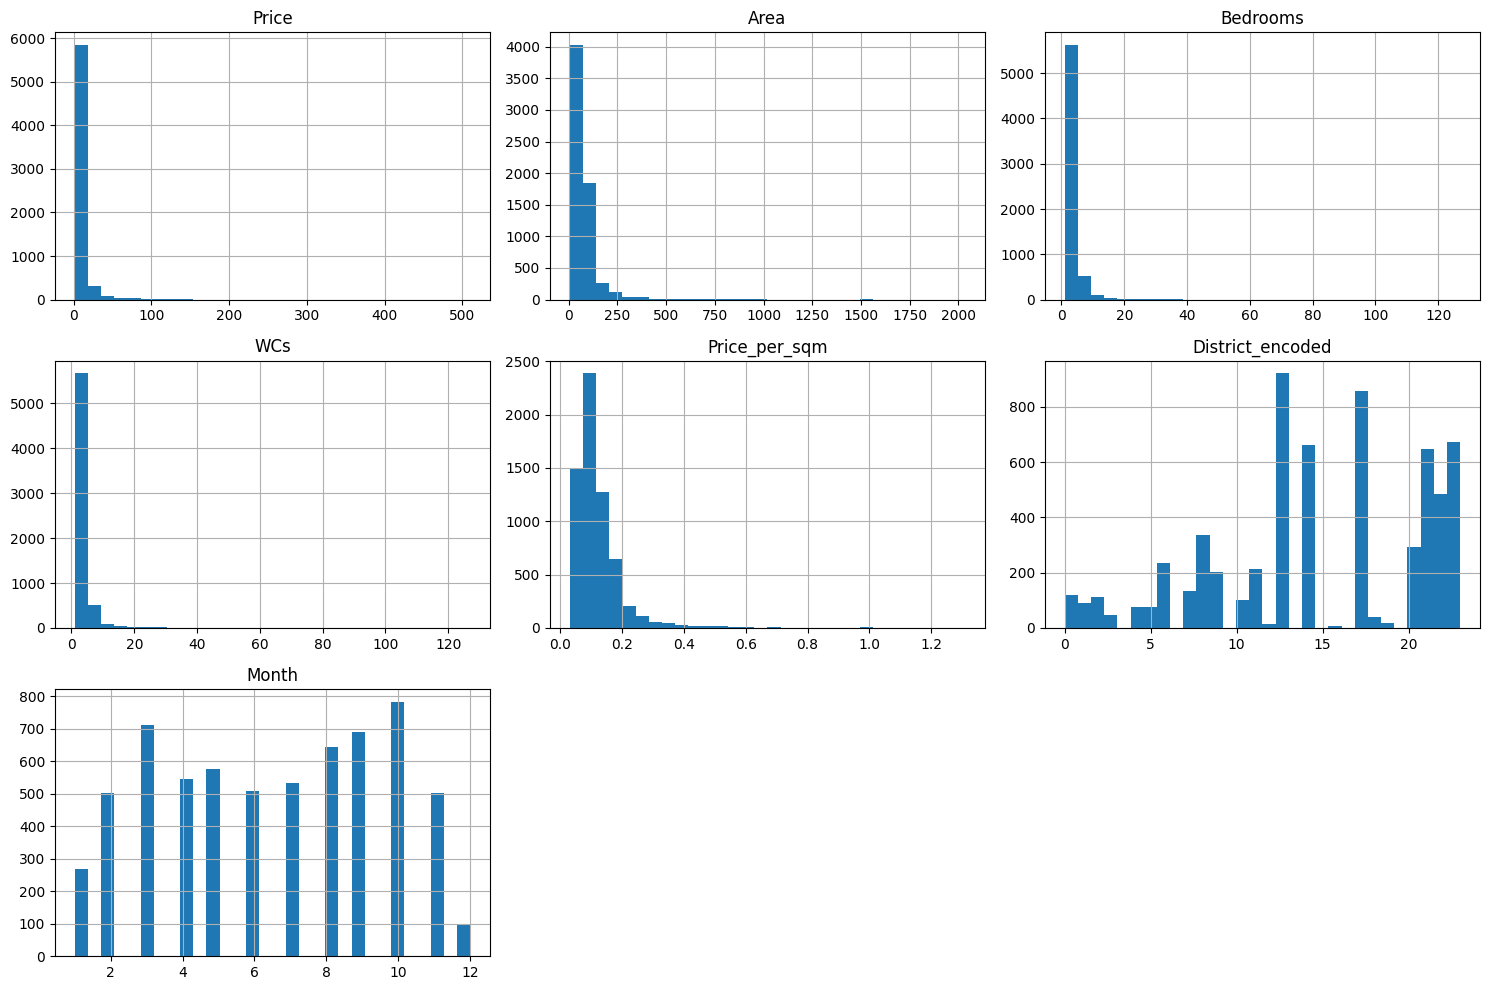

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
# Định nghĩa các biến số
numeric_features = ['Price', 'Area', 'Bedrooms', 'WCs', 'Price_per_sqm', 'District_encoded', 'Month']
# Vẽ Histogram cho các biến số
df[numeric_features].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

**Insights:**
*   Right-skewed distributions: For Price, Area, Price_per_sqm, Bedrooms, and WCs, the right-skewed distributions indicate that most properties fall within a lower range for these attributes, with fewer properties having significantly higher values.
*   Outliers: There are noticeable outliers, especially in the Price, Area, Bedrooms, and WCs features, which could affect modeling and analysis.
*   Uniform distributions: The more uniform distribution of District_encoded and Month suggests a balanced representation of districts and months in dataset.

                     Price      Area  Bedrooms       WCs  District_encoded  \
Price             1.000000  0.683837  0.388474  0.358994         -0.122867   
Area              0.683837  1.000000  0.439386  0.431339         -0.014315   
Bedrooms          0.388474  0.439386  1.000000  0.926284         -0.047083   
WCs               0.358994  0.431339  0.926284  1.000000         -0.039987   
District_encoded -0.122867 -0.014315 -0.047083 -0.039987          1.000000   
Month             0.023665 -0.002024  0.006466 -0.008334          0.043023   

                     Month  
Price             0.023665  
Area             -0.002024  
Bedrooms          0.006466  
WCs              -0.008334  
District_encoded  0.043023  
Month             1.000000  


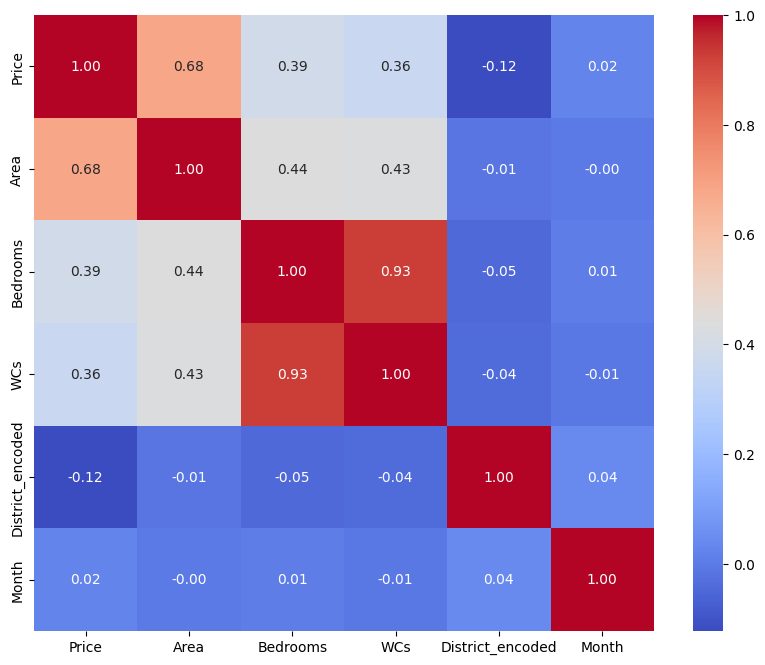

In [55]:
# Tính toán ma trận tương quan mà không bao gồm cột 'Price_per_sqm'
corr_matrix = df[numeric_features].drop(columns=['Price_per_sqm']).corr()

# Hiển thị ma trận tương quan
print(corr_matrix)

# Vẽ Heatmap cho ma trận tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()



*   The most significant factor affecting the price is the area of the property.
*   The number of bedrooms and WCs also has a noticeable impact on the price, although less so than the area.
*   The number of bedrooms and WCs also has a noticeable impact on the price, although less so than the area.
The district and month have minimal impact on the price.








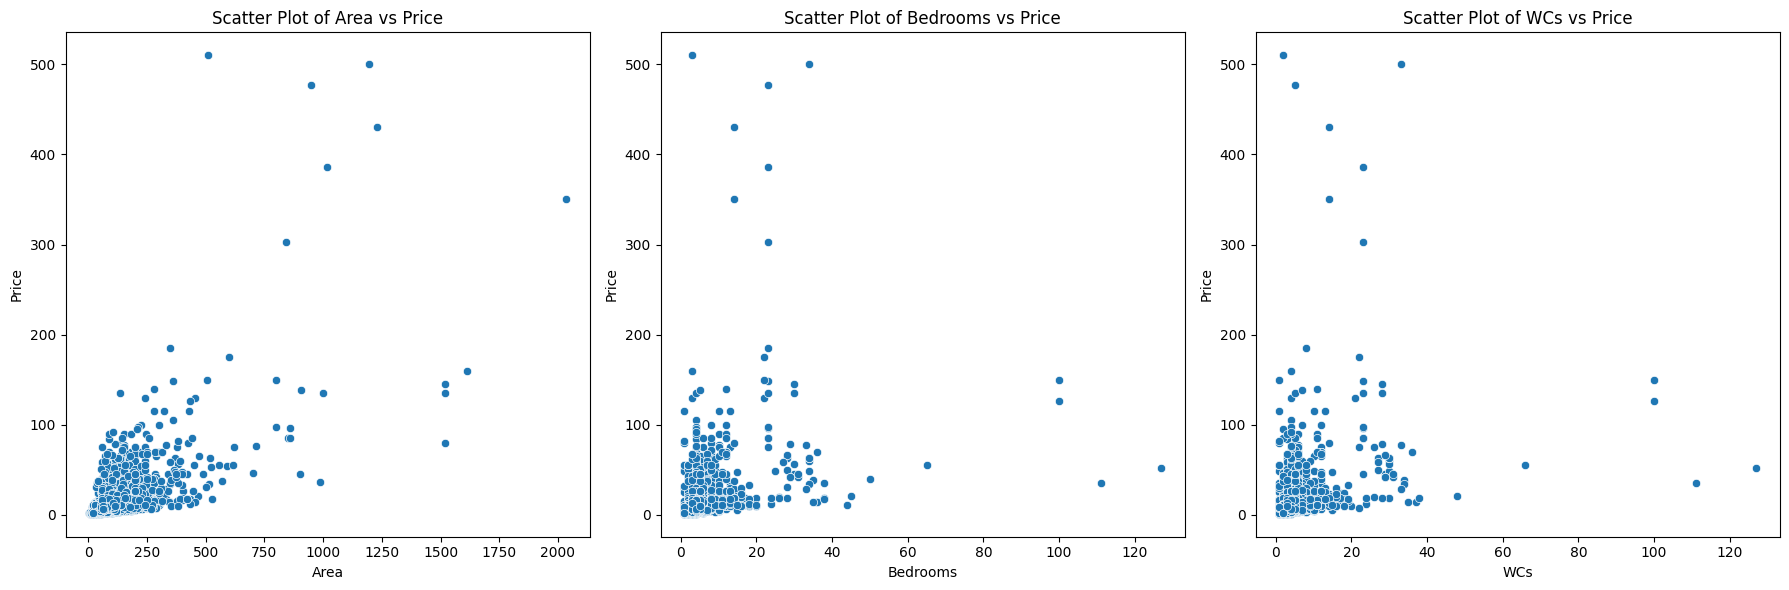

In [57]:
# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot between Area and Price
sns.scatterplot(x='Area', y='Price', data=df, ax=axes[0])
axes[0].set_title('Scatter Plot of Area vs Price')

# Scatter plot between Bedrooms and Price
sns.scatterplot(x='Bedrooms', y='Price', data=df, ax=axes[1])
axes[1].set_title('Scatter Plot of Bedrooms vs Price')

# Scatter plot between WCs and Price
sns.scatterplot(x='WCs', y='Price', data=df, ax=axes[2])
axes[2].set_title('Scatter Plot of WCs vs Price')

# Adjust layout
plt.tight_layout()
plt.show()


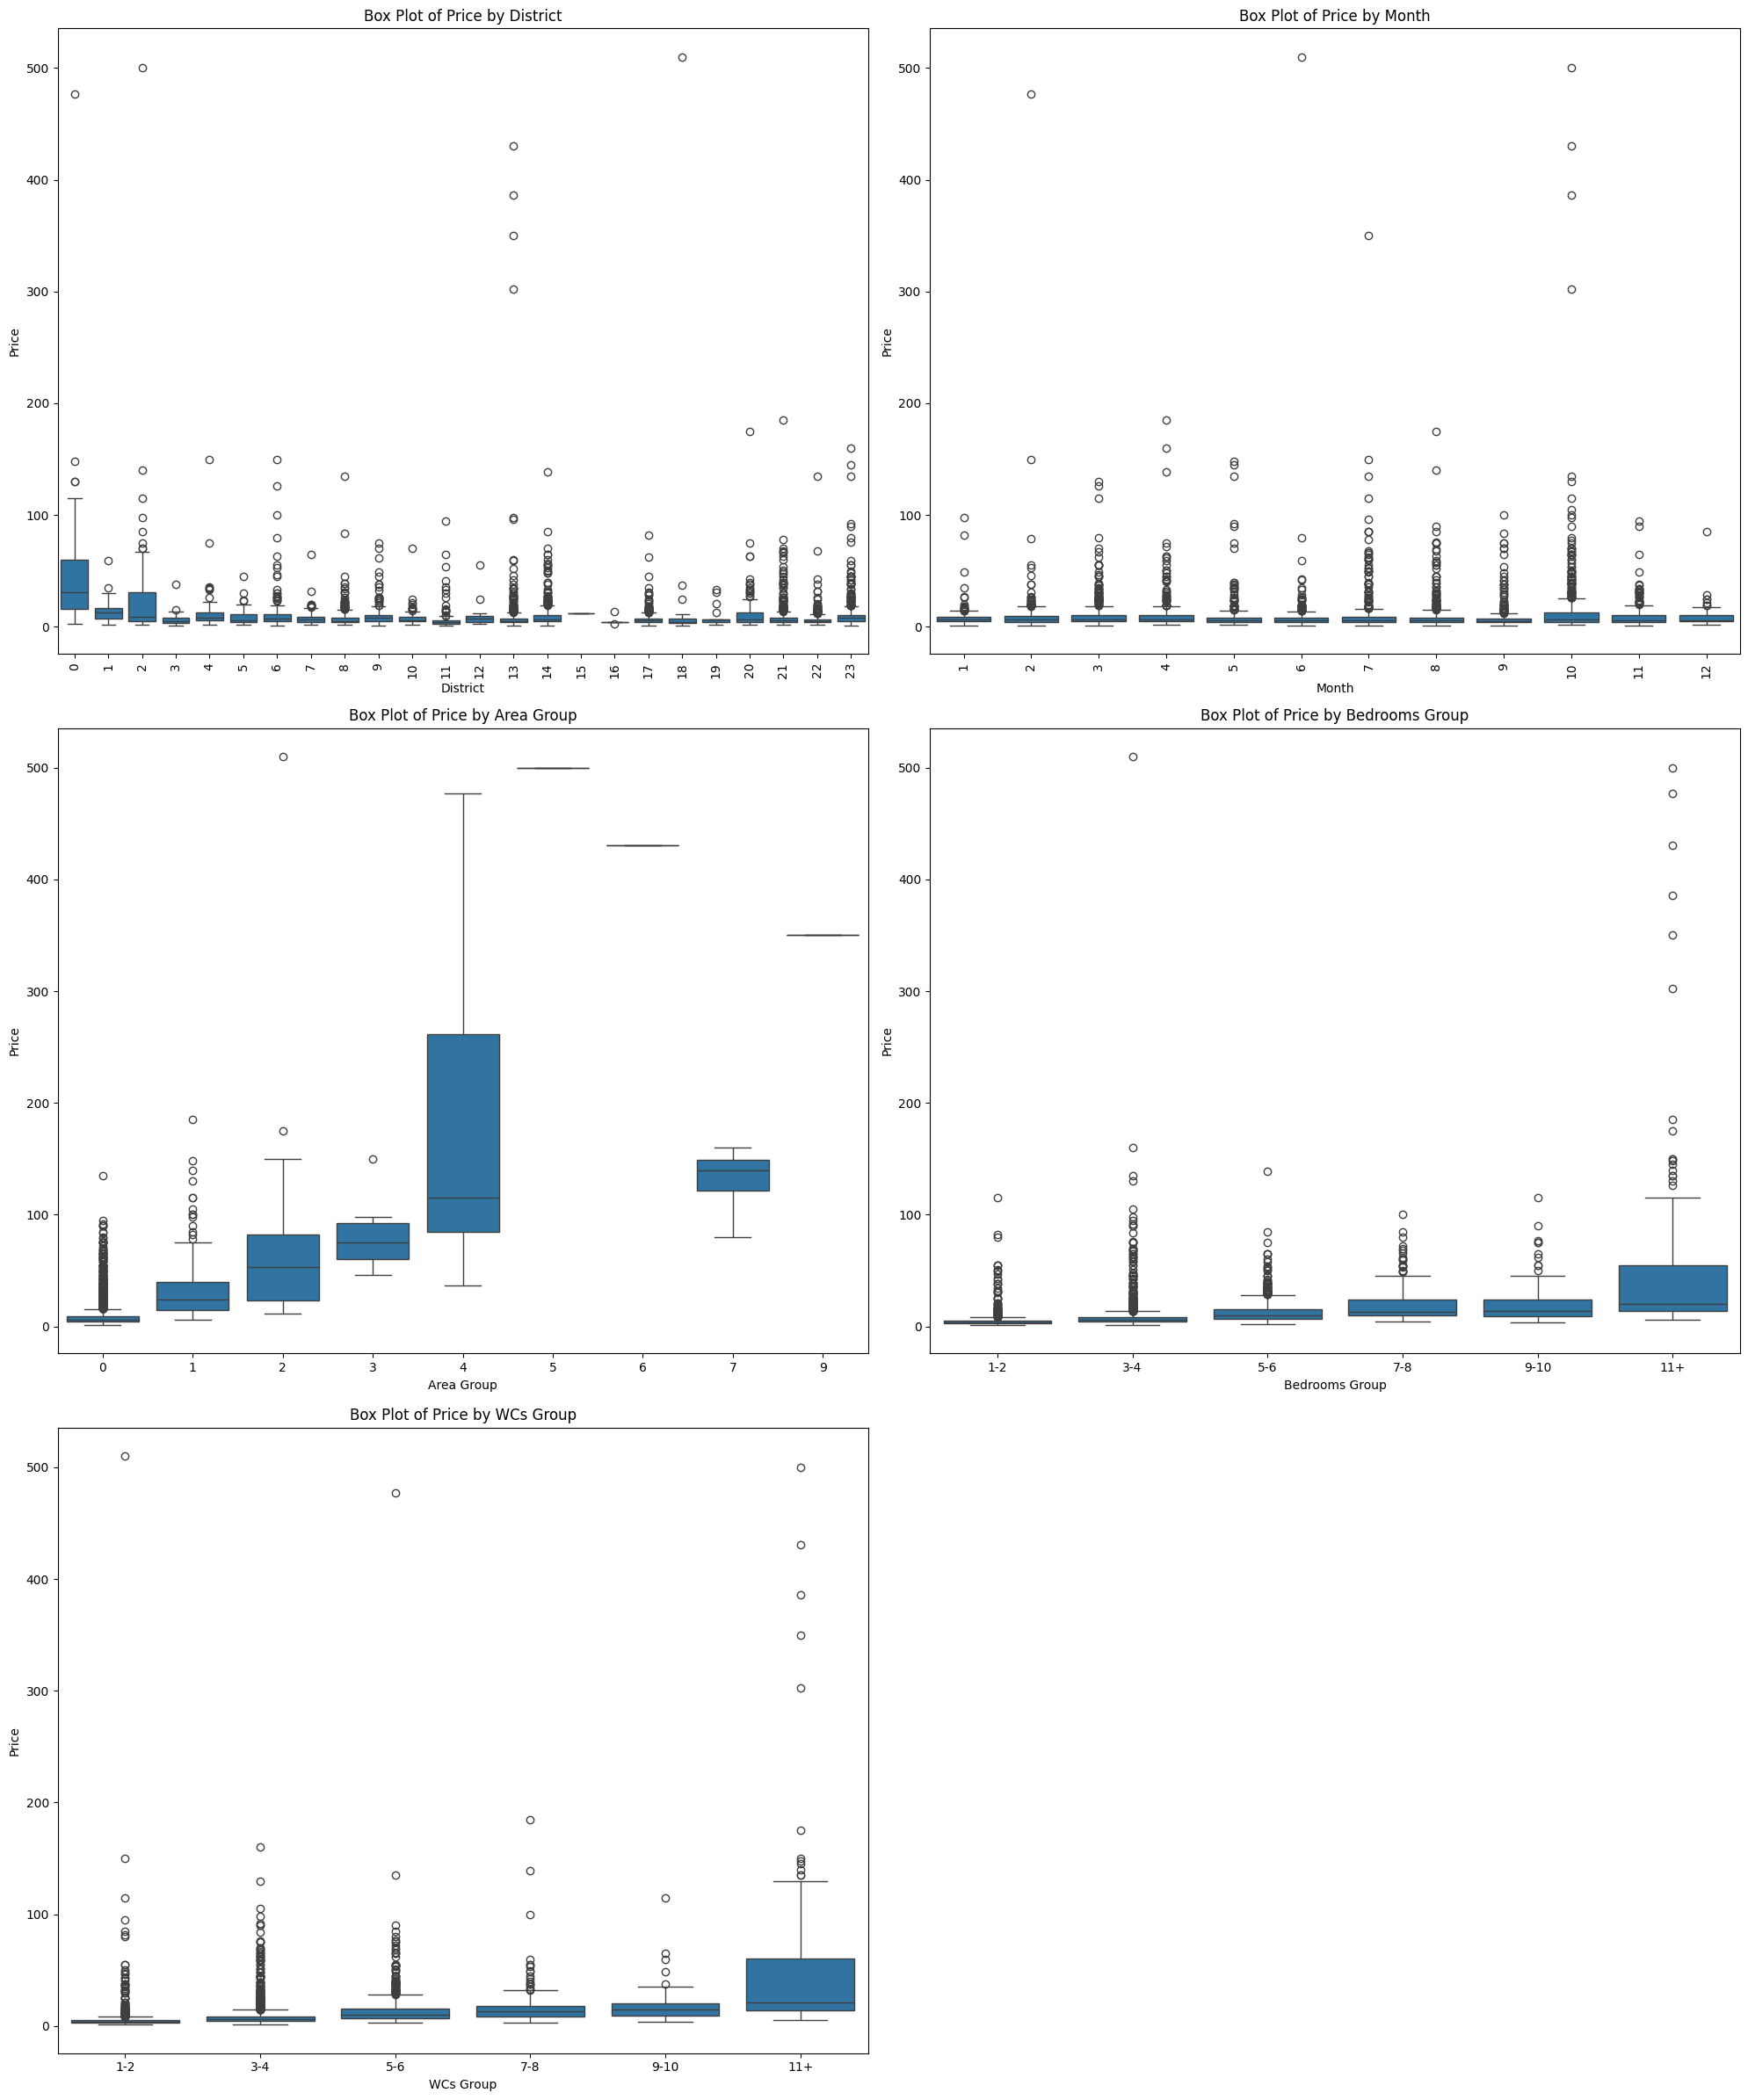

In [58]:
# Chia Area thành các nhóm (bins) để dễ so sánh
df['Area_group'] = pd.cut(df['Area'], bins=10, labels=False)
# Group Bedrooms and WCs into fewer categories
df['Bedrooms_group'] = pd.cut(df['Bedrooms'], bins=[0, 2, 4, 6, 8, 10, float('inf')], labels=['1-2', '3-4', '5-6', '7-8', '9-10', '11+'])
df['WCs_group'] = pd.cut(df['WCs'], bins=[0, 2, 4, 6, 8, 10, float('inf')], labels=['1-2', '3-4', '5-6', '7-8', '9-10', '11+'])

# Tạo figure với nhiều subplot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 24))

# Box plot của Price theo District_encoded
sns.boxplot(ax=axes[0, 0], x='District_encoded', y='Price', data=df)
axes[0, 0].set_title('Box Plot of Price by District')
axes[0, 0].set_xlabel('District')
axes[0, 0].set_ylabel('Price')
axes[0, 0].tick_params(axis='x', rotation=90)

# Box plot của Price theo Month
sns.boxplot(ax=axes[0, 1], x='Month', y='Price', data=df)
axes[0, 1].set_title('Box Plot of Price by Month')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Price')
axes[0, 1].tick_params(axis='x', rotation=90)

# Box plot của Price theo Area_group
sns.boxplot(ax=axes[1, 0], x='Area_group', y='Price', data=df)
axes[1, 0].set_title('Box Plot of Price by Area Group')
axes[1, 0].set_xlabel('Area Group')
axes[1, 0].set_ylabel('Price')

# Box plot của Price theo Bedrooms group
sns.boxplot(ax=axes[1, 1], x='Bedrooms_group', y='Price', data=df)
axes[1, 1].set_title('Box Plot of Price by Bedrooms Group')
axes[1, 1].set_xlabel('Bedrooms Group')
axes[1, 1].set_ylabel('Price')

# Box plot của Price theo WCs group
sns.boxplot(ax=axes[2, 0], x='WCs_group', y='Price', data=df)
axes[2, 0].set_title('Box Plot of Price by WCs Group')
axes[2, 0].set_xlabel('WCs Group')
axes[2, 0].set_ylabel('Price')

# Loại bỏ subplot trống
fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()


*   Price by District:
     + Significant variation in house prices across districts.
     + Presence of high outliers in some districts.
*   Price by Month:
     + Fairly even distribution of prices across months.
     + Some months have high outliers.
*   Price by Area Group:
     + Prices tend to increase with larger area groups.
     + Higher area groups show more high outliers.
*   Price by Bedrooms:
     + More bedrooms generally correlate with higher prices, but with many outliers.
     + Higher bedroom counts (e.g., 9-10, 11+) show higher median prices.
*   Price by WCs:
     + More WCs tend to correlate with higher prices, but with many outliers.
     + Higher WC counts (e.g., 9-10, 11+) show higher median prices.

In [59]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Loại bỏ ngoại lệ cho cột Price
df_no_outliers = remove_outliers(df, 'Price')

# Xóa các cột không cần thiết
columns_to_drop = ['District', 'Postdate','Description','Area_group', 'Bedrooms_group', 'WCs_group', 'Extracted_Price', 'Extracted_Area', 'Extracted_Bedrooms', 'Extracted_WCs']
df_no_outliers = df_no_outliers.drop(columns=columns_to_drop)
# Xóa cột No hiện tại nếu tồn tại và thêm cột No mới
df_no_outliers = df_no_outliers.drop(columns=['No'], errors='ignore')

df_no_outliers.insert(0, 'No', range(1, len(df_no_outliers) + 1))

# Kiểm tra kết quả
print(df_no_outliers.describe())


               No        Price         Area     Bedrooms          WCs  \
count  5788.00000  5788.000000  5788.000000  5788.000000  5788.000000   
mean   2894.50000     6.534667    67.519841     3.564271     3.369039   
std    1670.99601     3.236901    37.405602     1.928526     1.887163   
min       1.00000     1.200000     5.000000     1.000000     1.000000   
25%    1447.75000     4.200000    45.000000     2.000000     2.000000   
50%    2894.50000     5.700000    60.000000     3.000000     3.000000   
75%    4341.25000     8.220000    80.000000     4.000000     4.000000   
max    5788.00000    17.400000   455.000000    44.000000    37.000000   

       Price_per_sqm  District_encoded        Month  
count    5788.000000       5788.000000  5788.000000  
mean        0.106971         15.096579     6.422426  
std         0.050327          5.945420     3.081525  
min         0.030000          0.000000     1.000000  
25%         0.070000         11.000000     4.000000  
50%         0.1000

In [61]:
from sklearn.preprocessing import StandardScaler

# Chuẩn bị các cột cần chuẩn hóa
columns_to_scale = ['Price', 'Area', 'Bedrooms', 'WCs', 'District_encoded', 'Month']

# Tạo đối tượng StandardScaler
scaler = StandardScaler()

# Áp dụng chuẩn hóa cho các cột đã chọn
df_scaled = df_no_outliers.copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df_no_outliers[columns_to_scale])

# Kiểm tra kết quả
print(df_scaled.head())


    No     Price      Area  Bedrooms       WCs  Price_per_sqm  \
3    1  2.152039 -0.628833 -0.292617 -0.725511           0.31   
6    2  0.669010 -0.602097 -0.292617 -0.195569           0.19   
8    3  0.854389 -0.735778  0.225958  0.334372           0.23   
22   4  2.615485  2.250396  0.744534  0.334372           0.10   
23   5  2.924449  2.250396  0.744534  0.334372           0.11   

    District_encoded     Month  
3          -2.539414  1.485618  
6          -2.539414  1.485618  
8          -2.539414  1.485618  
22         -2.539414  1.161076  
23         -2.539414  1.161076  


In [62]:
print(df_scaled.describe())

               No         Price          Area      Bedrooms           WCs  \
count  5788.00000  5.788000e+03  5.788000e+03  5.788000e+03  5.788000e+03   
mean   2894.50000  3.314557e-16  1.092576e-16  5.155977e-17 -7.611204e-17   
std    1670.99601  1.000086e+00  1.000086e+00  1.000086e+00  1.000086e+00   
min       1.00000 -1.648221e+00 -1.671548e+00 -1.329768e+00 -1.255453e+00   
25%    1447.75000 -7.213283e-01 -6.020966e-01 -8.111925e-01 -7.255111e-01   
50%    2894.50000 -2.578821e-01 -2.010525e-01 -2.926170e-01 -1.955694e-01   
75%    4341.25000  5.207077e-01  3.336729e-01  2.259584e-01  3.343723e-01   
max    5788.00000  3.356999e+00  1.035978e+01  2.096898e+01  1.782245e+01   

       Price_per_sqm  District_encoded         Month  
count    5788.000000      5.788000e+03  5.788000e+03  
mean        0.106971      1.571345e-16  3.437318e-17  
std         0.050327      1.000086e+00  1.000086e+00  
min         0.030000     -2.539414e+00 -1.759809e+00  
25%         0.070000     -6.890

In [63]:
# Xuất dữ liệu đã xử lý ra file CSV mới
df_scaled.to_csv('../Data/preprocessed_data.csv', index=False)